In [1]:
from sustaingym.envs.evcharging import EVChargingEnv, GMMsTraceGenerator, DiscreteActionWrapper
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import sklearn

/Users/so/miniforge3/envs/sustaingym_ev/lib/python3.10/site-packages/acnportal/acnsim/base.py:17: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


set new seed\
run through entire episode  (288 steps)\
save moer info

In [2]:
# Create events generator which samples events from a GMM trained on Caltech
# data. The 'jpl' site is also supported, along with the periods
# 'Fall 2019', 'Spring 2020' , and 'Summer 2021'.

gmmg = GMMsTraceGenerator('caltech', 'Summer 2021')
env = EVChargingEnv (gmmg)
env =DiscreteActionWrapper(env)

obs, _ = env.reset(seed=1)
terminated = False
info_2 = {}

n_timesteps = 289
i = 0
while not terminated:
    info_2[i] = {}
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info_d = env.step(action)
    info_2[i]['a'] = action
    info_2[i]['o'] = copy.deepcopy(obs)
    info_2[i]['r'] = reward
    info_2[i]['trunc'] = truncated
    info_2[i]['info'] = copy.deepcopy(info_d)
    i += 1

/Users/so/miniforge3/envs/sustaingym_ev/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
gmmg = GMMsTraceGenerator('caltech', 'Summer 2021')
env = EVChargingEnv (gmmg)
env =DiscreteActionWrapper(env)

errors = {}
n_seeds = 50
for seed in range(1, n_seeds):
    obs, _ = env.reset(seed=seed)
    terminated = False

    time_step = 0
    forecasts = {}
    error_d = {}
    actual_moers = []

    # forecast for t = 0
    forecasts[time_step] = obs['forecasted_moer']

    while not terminated:
        action = env.action_space.sample()
        obs, _, terminated, _, _ = env.step(action)
        actual_moers.append(obs['prev_moer'][0])
        forecasts[time_step] = obs['forecasted_moer']
        time_step += 1

    # create shifting window
    for step in range(len(actual_moers)):
        window = actual_moers[step : step + 36]
        forecast = forecasts[step]
        if len(window) < 36:
            forecast = forecast[:len(window)] # if window is shorter than 36 (for the end), align forecast
            error = window - forecast
            error = np.pad(error, (0, 36 - len(error)), mode="constant")
        else:
            error = window - forecast
        error_d[step] = error
    errors[seed] = error_d

In [23]:
dfs = []
for seed in range(1, 50):
    dfs.append(pd.DataFrame(errors[seed]).T)

In [ ]:
ts_errors = []
for row in range(dfs[0].shape[0]):
    d = {}
    for seed in range(len(dfs)):
        d[seed] = dfs[seed].iloc[row].values
    # pd.DataFrame(d).T.to_csv(f'moer_vars/ts_{row}.csv')
    ts_errors.append(pd.DataFrame(d).T)

In [ ]:
# for making plots of errors by timestep

# for row in range(dfs[0].shape[0]):
#     d = {}
#     for seed in range(len(dfs)):
#         d[seed] = dfs[seed].iloc[row].values
#     temp = pd.DataFrame(d)
#     for col in temp:
#         plt.plot(temp[col])
#     plt.savefig(f'error_plots_by_timestep/time_step_{row}.png')
#     plt.clf()

<Figure size 640x480 with 0 Axes>

In [111]:
for ts in range(len(ts_errors)):
    ts_errors[ts].to_csv(f'moer_vars/by_ts/ts_{ts}.csv')

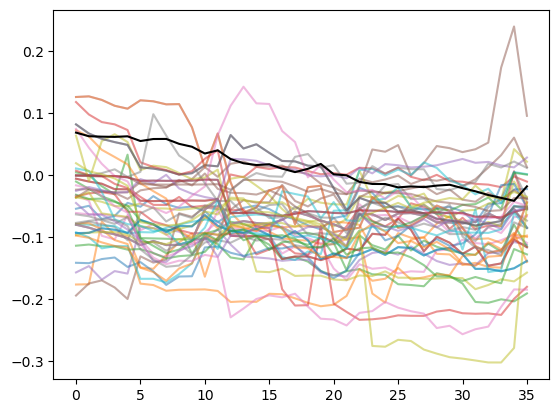

In [152]:
ts = 96

pca = sklearn.decomposition.PCA()
pca.fit(ts_errors[ts])

for row in range(len(ts_errors[ts])):
    plt.plot(ts_errors[ts].iloc[row], alpha = 0.5)
plt.plot(pca.components_[1] * np.sqrt(pca.explained_variance_[1]), color = 'black')

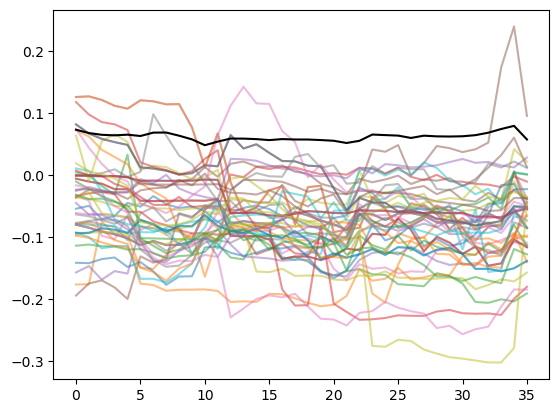

In [153]:
for row in range(len(ts_errors[ts])):
    plt.plot(ts_errors[ts].iloc[row], alpha = 0.5)
plt.plot(np.std(ts_errors[ts]), color = 'black')

In [29]:
error_mag_by_time = []
for i in range(len(ts_errors)):
    error_mag_by_time.append(np.linalg.norm(ts_errors[i], axis = 1).mean())

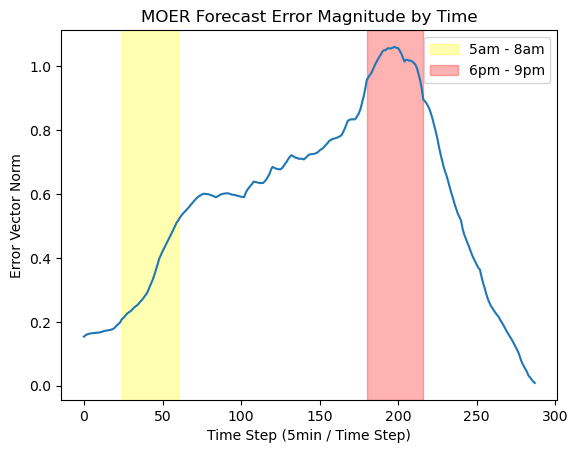

In [30]:
plt.plot(error_mag_by_time)
plt.title('MOER Forecast Error Magnitude by Time')
plt.ylabel('Error Vector Norm')
plt.xlabel('Time Step (5min / Time Step)')

# Highlight range: 5am to 7am (Timesteps 60 to 84)
plt.axvspan(60 - 36, 96 - 36, color='yellow', alpha=0.3, label='5am - 8am')

# Highlight range: 7pm to 9pm (Timesteps 234 to 252)
plt.axvspan(216 - 36, 252 - 36, color='red', alpha=0.3, label='6pm - 9pm')
plt.legend()

In [31]:
error_by_timesteps = {}
for ts in range(len(ts_errors)):
    error_by_timesteps[ts] = np.std(ts_errors[ts])

In [33]:
pd.DataFrame(error_by_timesteps).T.to_csv('moer_vars/error_std.csv')